In [1]:
"""
This code generates images optimized to activate each of the 5 classes currently recognized by our landscape architecture neural network.
Essentially, the method holds the network parameters fixed and maximizes the final output scores with respect to the input pixels. The input for
each class is  initialized as an average across the training images belonging to that class, an idea taken from:

@article{nguyen2016multifaceted,
  title={Multifaceted Feature Visualization: Uncovering the Different Types of Features Learned By Each Neuron in Deep Neural Networks},
  author={Nguyen, Anh and Yosinski, Jason and Clune, Jeff},
  journal={Visualization for Deep Learning workshop, International Conference in Machine Learning},
  note={arXiv preprint arXiv:1602.03616},
  year={2016}
}

The optimization and image generation code (OptimalImage class) was copied almost directly from:
@misc{uozbulak_pytorch_vis_2019,
  author = {Utku Ozbulak},
  title = {PyTorch CNN Visualizations},
  year = {2019},
  publisher = {GitHub},
  journal = {GitHub repository},
  howpublished = {\url{https://github.com/utkuozbulak/pytorch-cnn-visualizations}},
  commit = {3460e7f014f52f4099c1a4864e1534de9cc901e7}
}

I just changed the initialization from a random image to the averaged image as described above. 
"""

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 1076-1077: truncated \uXXXX escape (<ipython-input-1-af807d3f69ad>, line 26)

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.optim import SGD
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from PIL import ImageFile
import glob

In [2]:
# Generate mean-valued class image to initialize optimization (mean across images)

path = "Capstone/lsi/BinaryClassifierExperiment/Images/Training/Designed Landscape"

def center_crop(img,size,resize = 255):     # square center crop
        
        # Load Image
        img = Image.open(img)
        if img.mode == "RGB": #check that image is color to prevent issues with array dimensionality
           
            # Get the dimensions of the image
            width, height = img.size
    
            # Resize by keeping the aspect ratio, but changing the dimension of shortest side

            img = img.resize((resize, int(resize*(height/width))) if width < height else (int(resize*(width/height)), resize))
    
            # Get the dimensions of the new image size
            width, height = img.size
    
            # Set the coordinates to do a center crop 
            left = (width - size)/2
            top = (height - size)/2
            right = (width + size)/2
            bottom = (height + size)/2
            img = img.crop((left, top, right, bottom))
            return img
 
    
def to_array(img):
        image = img
        #image = Image.open(img)
        # Turn image into numpy array
        img = np.array(img)  
        # Make the color channel dimension first instead of last
        img = img.transpose((2, 0, 1))
        # Make all values between 0 and 1
        img = img/255 
        return img

def mean_image(class_dir):
    
    mean_init = np.zeros((3,224,224))
    all_files = glob.glob(class_dir + "*.jpg") # list of all images

    for file in all_files:
        try:
            img = to_array(center_crop(file,224)) 
        except ValueError:   #disregard black and white images because the channels don't match expected input
            continue
        mean_init[0,:,:] += img[0,:,:]
        mean_init[1,:,:] += img[1,:,:]
        mean_init[2,:,:] += img[2,:,:]
    print(len(all_files))
    #mean_init = mean_init / len(all_files)
    # Add a fourth dimension to the beginning to indicate batch size
    mean_init = mean_init[np.newaxis,:]
    
# Turn into a differentiable torch tensor 
def make_var(image):
    image = torch.from_numpy(image)
    image = image.float()
    image = image.to(device = "cuda")
    image.requires_grad = True
    return image

def random_image(h,w):
    image = np.uint8(np.random.uniform(0, 255, (3, h, w)))
    image = torch.from_numpy(image)
    image = image.float()
    image = torch.div(image,torch.max(image))
    image.unsqueeze_(0)
    image = image.to(device = "cuda")
    return image

dtype = torch.FloatTensor

# Show Image
def show_image(image):
    # Convert image to numpy
    image = torch.mul(image,255)
    image = image.detach().numpy()
    image = np.transpose(image[0],(1,2,0))
    im = Image.fromarray(image.astype('uint8')).convert('RGBA')
    # Print the image
    fig = plt.figure(figsize=(25, 4))
    plt.imshow(im)
    #plt.imshow(np.transpose(image[0]))
    
#Save Image
def save_image(image,file_name):
    image = image.numpy()
    image = np.transpose(image[0], (1,2,0))
    image = image.astype(np.uint8)
    image = Image.fromarray(image)
    image.save(file_name)

In [4]:
# Load network
ArchNet = torch.load('LandscapeNet_imagenet_pretrained')
ArchNet_places = torch.load('LandscapeNet_places365pretrained')
ArchNet.eval()
ArchNet_places.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [6]:
class OptimalImage():
    
        def __init__(self, model, target_class, initial): 
            self.initial = make_var(initial)
            self.model = model
            self.model.eval()
            self.target_class = target_class
            self.image = make_var(initial)
        def optimize(self,method = None):
            lr = .006
            # Define optimizer for the image
            optimizer = SGD([self.image], lr=lr)
            for i in range(1, 500):
                # Target specific class
                if not method:
                    class_loss = -self.model(self.image)[0, self.target_class]
                elif method == "mute_colors":
                    # Max channel value per pixel, used to penalize high intensity pixels in loss function.
                    class_loss = -self.model(self.image)[0, self.target_class] + 80*torch.flatten(DesignedLandscape.image.max(1)[0]).mean()
                elif method == "distance_from_mean":
                    # Adds L2 distance from initial mean image to loss function
                    class_loss = -self.model(self.image)[0, self.target_class] + 10*torch.dist(self.image,self.initial,p=2)
                if i % 100 == 0:
                    lr *= .75
                    optimizer = SGD([self.image],lr=lr)
                    print('Iteration:', str(i), 'Loss', "{0:.2f}".format(class_loss.cpu().data.numpy()))
                # Zero grads
                self.model.zero_grad()
                # Backward
                class_loss.backward()
                # Update image
                optimizer.step()
            #self.image.requires_grad = False
            return self.image
        

In [7]:
natural_init = np.load("natural_init.npy")
designed_init = np.load("designed_init.npy")

In [8]:
# ImageNet - Designed - Final Layer

In [9]:
ImageFile.LOAD_TRUNCATED_IMAGES = True # So PIL doesn't complain about big images being cropped
DesignedLandscape = OptimalImage(ArchNet, 0, initial = designed_init)
image = DesignedLandscape.initial

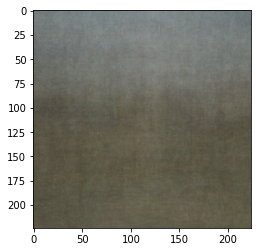

In [10]:
# initialization (mean image)
show_image(image.cpu())

In [11]:
DesignedLandscape.optimize()

Iteration: 100 Loss -6.49
Iteration: 200 Loss -15.16
Iteration: 300 Loss -19.15
Iteration: 400 Loss -21.15


tensor([[[[ 0.9547,  0.7900,  0.7154,  ...,  0.4226,  0.2366,  0.2545],
          [ 0.2708,  0.9754,  0.8224,  ...,  0.5525,  0.2887,  0.2485],
          [-0.2357,  0.6821,  0.8507,  ...,  0.5439,  0.5778,  0.4249],
          ...,
          [ 0.5600,  0.9362,  1.0043,  ...,  0.7829,  0.3612,  0.1677],
          [ 0.5521,  0.8165,  0.4729,  ...,  0.4441,  0.5077,  0.2551],
          [ 0.4868,  0.2906,  0.3327,  ...,  0.4292,  0.5497,  0.1411]],

         [[ 0.8163,  0.4875,  0.2879,  ...,  0.4630,  0.1839,  0.2723],
          [-0.0704,  0.6935,  0.4186,  ...,  0.5887,  0.2208,  0.2718],
          [-0.6749,  0.4136,  0.5624,  ...,  0.5734,  0.5893,  0.5147],
          ...,
          [ 0.3731,  0.6195,  0.4558,  ...,  0.5626,  0.1451, -0.1016],
          [ 0.4711,  0.5920,  0.1498,  ...,  0.2032,  0.3406,  0.0030],
          [ 0.5184,  0.3075,  0.3851,  ...,  0.2767,  0.4732, -0.0244]],

         [[ 0.8303,  0.5867,  0.5027,  ...,  0.4274,  0.3100,  0.4279],
          [ 0.3324,  0.8161,  

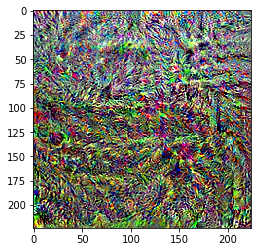

In [12]:
img = DesignedLandscape.image
maxv = torch.max(img)
im = torch.div(img,maxv)
im = torch.clamp(img,0,1)
show_image(im.cpu())

In [13]:
# Adding penalty for high pixel values 

Iteration: 100 Loss 24.77
Iteration: 200 Loss 14.74
Iteration: 300 Loss 8.57
Iteration: 400 Loss 2.97


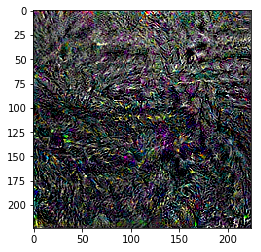

In [14]:
DesignedLandscape = OptimalImage(ArchNet, 0, initial = designed_init)
DesignedLandscape.optimize(method = "mute_colors")
img = DesignedLandscape.image
maxv = torch.max(img)
im = torch.div(img,maxv)
im = torch.clamp(img,0,1)
show_image(im.cpu())

In [15]:
# Places365 - Designed - Final Layer

In [16]:
DesignedLandscape = OptimalImage(ArchNet_places, 0, initial = designed_init)
image = DesignedLandscape.image

In [17]:
DesignedLandscape.optimize()

Iteration: 100 Loss -1.21
Iteration: 200 Loss -2.16
Iteration: 300 Loss -2.85
Iteration: 400 Loss -3.40


tensor([[[[0.1424, 0.4261, 0.7156,  ..., 0.4860, 0.3441, 0.3430],
          [0.1630, 0.4206, 0.6166,  ..., 0.4977, 0.4344, 0.3629],
          [0.2665, 0.3668, 0.4806,  ..., 0.5837, 0.5860, 0.5198],
          ...,
          [0.3782, 0.3368, 0.2780,  ..., 0.3969, 0.3431, 0.3607],
          [0.4406, 0.3737, 0.2839,  ..., 0.4041, 0.3568, 0.4252],
          [0.4860, 0.4011, 0.2438,  ..., 0.3411, 0.3341, 0.4314]],

         [[0.2274, 0.5385, 0.8230,  ..., 0.5210, 0.3474, 0.3387],
          [0.2453, 0.5253, 0.7073,  ..., 0.5432, 0.4512, 0.3667],
          [0.2997, 0.3889, 0.5045,  ..., 0.6625, 0.6360, 0.5541],
          ...,
          [0.4726, 0.4501, 0.3965,  ..., 0.5313, 0.3809, 0.3992],
          [0.5074, 0.4469, 0.3542,  ..., 0.5320, 0.4101, 0.4825],
          [0.5496, 0.4741, 0.3026,  ..., 0.4820, 0.3951, 0.5021]],

         [[0.3263, 0.5718, 0.8510,  ..., 0.5294, 0.4029, 0.3956],
          [0.3408, 0.5634, 0.7530,  ..., 0.4922, 0.4496, 0.3777],
          [0.3646, 0.4341, 0.5544,  ..., 0

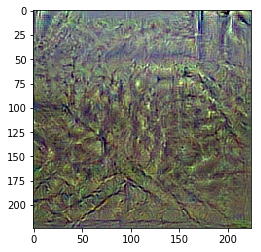

In [19]:
img = DesignedLandscape.image
maxv = torch.max(img)
im = torch.div(img,maxv)
im = torch.clamp(img,0,1)
show_image(im.cpu())

In [20]:
# Adding penalty for high pixel values

Iteration: 100 Loss 30.08
Iteration: 200 Loss 25.86
Iteration: 300 Loss 22.08
Iteration: 400 Loss 17.79


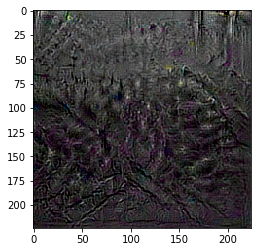

In [21]:
DesignedLandscape = OptimalImage(ArchNet_places, 0, initial = designed_init)
DesignedLandscape.optimize(method = "mute_colors")
img = DesignedLandscape.image
maxv = torch.max(img)
im = torch.div(img,maxv)
im = torch.clamp(img,0,1)
show_image(im.cpu())

In [22]:
# ImageNet - Natural - Final Layer

In [23]:
NaturalLandscape = OptimalImage(ArchNet, 1, initial = natural_init)
image = NaturalLandscape.image

In [24]:
NaturalLandscape.optimize()

Iteration: 100 Loss -9.62
Iteration: 200 Loss -16.23
Iteration: 300 Loss -19.13
Iteration: 400 Loss -20.88


tensor([[[[0.4020, 0.2811, 0.4636,  ..., 0.5824, 0.7960, 0.5573],
          [0.3599, 0.1127, 0.4919,  ..., 0.6247, 0.5937, 0.4654],
          [0.1472, 0.0839, 0.3771,  ..., 0.3335, 0.3686, 0.5041],
          ...,
          [0.4244, 0.1793, 0.5062,  ..., 0.4272, 0.2338, 0.2401],
          [0.3081, 0.3384, 0.8435,  ..., 0.4092, 0.2988, 0.2120],
          [0.3095, 0.3583, 0.4716,  ..., 0.4028, 0.3636, 0.2607]],

         [[0.6462, 0.6302, 0.6876,  ..., 0.8054, 0.9712, 0.6621],
          [0.8095, 0.7110, 0.9100,  ..., 0.6439, 0.6322, 0.4679],
          [0.4804, 0.6014, 0.5741,  ..., 0.2879, 0.3290, 0.5108],
          ...,
          [0.4969, 0.4887, 0.9955,  ..., 0.4005, 0.2121, 0.1909],
          [0.2962, 0.4819, 1.0489,  ..., 0.4112, 0.2061, 0.0825],
          [0.2596, 0.3794, 0.4664,  ..., 0.4360, 0.3052, 0.1765]],

         [[0.6725, 0.8328, 0.9619,  ..., 0.6229, 0.7722, 0.6087],
          [0.7727, 0.8907, 1.2545,  ..., 0.6112, 0.5505, 0.4866],
          [0.6746, 1.0025, 1.2837,  ..., 0

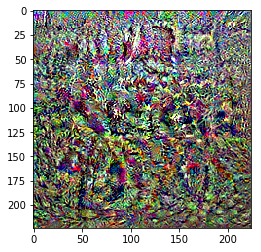

In [25]:
img = NaturalLandscape.image
maxv = torch.max(img)
im = torch.div(img,maxv)
im = torch.clamp(img,0,1)
show_image(im.cpu())

In [26]:
# Adding pixel value penalty

In [27]:
NaturalLandscape = OptimalImage(ArchNet, 1, initial = natural_init)
NaturalLandscape.optimize(method = "mute_colors")

Iteration: 100 Loss 7.57
Iteration: 200 Loss 1.06
Iteration: 300 Loss -1.90
Iteration: 400 Loss -3.71


tensor([[[[ 0.6793,  0.3437,  0.4470,  ...,  0.5840,  0.6961,  0.6081],
          [ 0.3148,  0.3531,  0.6304,  ...,  0.5998,  0.3928,  0.4714],
          [ 0.2998,  0.4293,  0.1287,  ...,  0.2568,  0.3475,  0.5318],
          ...,
          [ 0.4104,  0.2494,  0.4652,  ...,  0.2975,  0.2349,  0.2424],
          [ 0.3578,  0.3038,  0.8689,  ...,  0.3739,  0.2634,  0.2387],
          [ 0.3567,  0.3909,  0.4364,  ...,  0.4711,  0.3716,  0.3092]],

         [[ 0.8953,  0.5468,  0.5185,  ...,  0.7133,  0.8567,  0.7556],
          [ 0.6002,  0.6538,  0.7159,  ...,  0.5866,  0.4868,  0.5986],
          [ 0.3852,  0.5378, -0.0830,  ...,  0.2501,  0.5189,  0.7672],
          ...,
          [ 0.4644,  0.4579,  0.8259,  ...,  0.2560,  0.1888,  0.1817],
          [ 0.3374,  0.4267,  1.1329,  ...,  0.3493,  0.1656,  0.1331],
          [ 0.3346,  0.4029,  0.4514,  ...,  0.4937,  0.3207,  0.2568]],

         [[ 0.8865,  0.7656,  0.8169,  ...,  0.5612,  0.6783,  0.6587],
          [ 0.6999,  0.8741,  

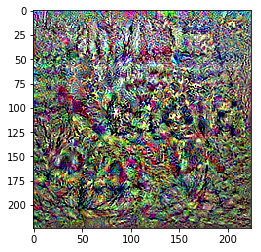

In [28]:
img = NaturalLandscape.image
maxv = torch.max(img)
im = torch.div(img,maxv)
im = torch.clamp(img,0,1)
show_image(im.cpu())

In [29]:
# Places365 - Natural - Final Layer

In [30]:
NaturalLandscape = OptimalImage(ArchNet_places, 1, initial = natural_init)
image = NaturalLandscape.image

In [103]:
ArchNet_places(image)

tensor([[ 0.4854,  6.6246, -0.2005]], device='cuda:0', grad_fn=<AddmmBackward>)

In [31]:
NaturalLandscape.optimize()

Iteration: 100 Loss -1.67
Iteration: 200 Loss -3.56
Iteration: 300 Loss -4.99
Iteration: 400 Loss -5.96


tensor([[[[0.4916, 0.5882, 0.5783,  ..., 0.4032, 0.4975, 0.5451],
          [0.3775, 0.5138, 0.4764,  ..., 0.3933, 0.4456, 0.4996],
          [0.3498, 0.5069, 0.3959,  ..., 0.4641, 0.4220, 0.4670],
          ...,
          [0.2955, 0.1994, 0.2919,  ..., 0.2884, 0.3090, 0.3385],
          [0.3339, 0.3049, 0.2707,  ..., 0.2817, 0.2806, 0.2821],
          [0.3611, 0.3402, 0.3592,  ..., 0.3072, 0.3291, 0.3380]],

         [[0.4020, 0.5041, 0.4984,  ..., 0.4046, 0.5150, 0.5693],
          [0.2659, 0.3910, 0.3578,  ..., 0.3870, 0.4546, 0.5127],
          [0.2214, 0.3676, 0.2570,  ..., 0.4506, 0.4076, 0.4498],
          ...,
          [0.2280, 0.1128, 0.2713,  ..., 0.3528, 0.3233, 0.3573],
          [0.2684, 0.2337, 0.2356,  ..., 0.2961, 0.2886, 0.2909],
          [0.2930, 0.2670, 0.3206,  ..., 0.3361, 0.3480, 0.3600]],

         [[0.4862, 0.5531, 0.5382,  ..., 0.4415, 0.5282, 0.5628],
          [0.3624, 0.4691, 0.4375,  ..., 0.4299, 0.4765, 0.5172],
          [0.2989, 0.4429, 0.3502,  ..., 0

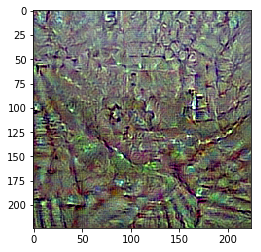

In [32]:
img = NaturalLandscape.image
maxv = torch.max(img)
im = torch.div(img,maxv)
im = torch.clamp(img,0,1)
show_image(im.cpu())

In [ ]:
# Adding pixel value penalty

Iteration: 100 Loss 15.60
Iteration: 200 Loss 13.73
Iteration: 300 Loss 12.27
Iteration: 400 Loss 11.34


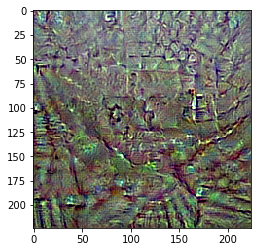

In [108]:
NaturalLandscape = OptimalImage(ArchNet_places, 1, initial = natural_init)
NaturalLandscape.optimize(method = "mute_colors")
img = NaturalLandscape.image
maxv = torch.max(img)
im = torch.div(img,maxv)
im = torch.clamp(img,0,1)
show_image(im.cpu())

In [ ]:
# Layer 2 nodes 100351, 1000, and 9367

In [365]:
class HiddenLayerOptimalImage():
        def __init__(self, model, initial): 
            self.initial = initial
            self.model = model
            #self.model.eval()
            self.image = make_var(initial)
            
        def reset(self):
            self.image = make_var(self.initial)
            
        def optimize(self,node):
            lr = .0005
            # Define optimizer for the image
            optimizer = SGD([self.image], lr=lr)
            for i in range(1, 400):
                # Target specific node
                class_loss = -torch.flatten(self.model(self.image))[node] + 1
                if i % 100 == 0:
                    lr *= .75
                    optimizer = SGD([self.image],lr=lr)
                    print('Iteration:', str(i), 'Loss', "{0:.2f}".format(class_loss.cpu().data.numpy()))
                # Zero grads
                self.model.zero_grad()
                # Backward
                class_loss.backward()
                # Update image
                optimizer.step()
            #self.image.requires_grad = False

            return self.image

In [300]:
# Subclass of resnet that only runs forward pass up to layer 2
import torchvision.models as models
from torchvision.models.resnet import ResNet, BasicBlock
class Layer2Activation(ResNet):
    def __init__(self):
        super(Layer2Activation, self).__init__(BasicBlock, [2, 2, 2, 2],num_classes = 3)
        for i in range(2):
            self.layer2[i].relu = torch.nn.RReLU()
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        return x

In [301]:
Layer2Places = Layer2Activation()
Layer2Places.load_state_dict(ArchNet_places.state_dict())
Layer2Places.to("cuda:0")
#for param in Layer2Places.parameters():
    #param.requires_grad = False

Layer2Activation(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (

In [302]:
Layer2_163 = HiddenLayerOptimalImage(Layer2Places,initial = natural_init)

In [303]:
Layer2_163.optimize(node = 100351)

Iteration: 100 Loss -16.77
Iteration: 200 Loss -18.11
Iteration: 300 Loss -18.41
Iteration: 400 Loss -18.65


tensor([[[[ 0.5132,  0.5839,  0.5181,  ...,  0.4906,  0.4336,  0.3696],
          [ 0.3975,  0.4349,  0.4511,  ...,  0.4905,  0.4775,  0.4094],
          [ 0.3288,  0.3248,  0.3649,  ...,  0.4540,  0.4767,  0.4286],
          ...,
          [ 0.3130,  0.3319,  0.3254,  ..., -0.0419,  0.4366,  0.5134],
          [ 0.3047,  0.3329,  0.3403,  ...,  0.1180,  0.9921,  0.6870],
          [ 0.3245,  0.3449,  0.3318,  ...,  0.6823,  0.9233,  0.2614]],

         [[ 0.5298,  0.5950,  0.5140,  ...,  0.5146,  0.4479,  0.3761],
          [ 0.3950,  0.4189,  0.4273,  ...,  0.5075,  0.4863,  0.4094],
          [ 0.3296,  0.3054,  0.3336,  ...,  0.4606,  0.4785,  0.4242],
          ...,
          [ 0.2746,  0.2918,  0.2727,  ...,  0.0251,  0.4230,  0.5125],
          [ 0.2662,  0.2887,  0.2900,  ...,  0.1515,  0.7778,  0.4575],
          [ 0.2866,  0.3061,  0.2866,  ...,  0.6246,  0.6104, -0.0886]],

         [[ 0.5161,  0.5691,  0.4969,  ...,  0.5150,  0.4681,  0.4098],
          [ 0.4218,  0.4441,  

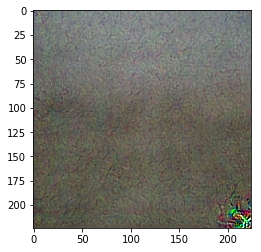

In [304]:
img = Layer2_163.image
maxv = torch.max(img)
im = torch.div(img,maxv)
im = torch.clamp(img,0,1)
show_image(im.cpu())

In [305]:
Layer2_163.reset()
Layer2_163.optimize(node = 1000)

Iteration: 100 Loss -13.30
Iteration: 200 Loss -15.90
Iteration: 300 Loss -16.63
Iteration: 400 Loss -17.08


tensor([[[[0.4304, 0.4587, 0.4765,  ..., 0.4580, 0.4702, 0.4698],
          [0.4082, 0.4516, 0.4804,  ..., 0.4473, 0.4570, 0.4516],
          [0.4267, 0.4487, 0.4754,  ..., 0.4265, 0.4376, 0.4396],
          ...,
          [0.2906, 0.3249, 0.3271,  ..., 0.3731, 0.3515, 0.3567],
          [0.3222, 0.3415, 0.3127,  ..., 0.3604, 0.3285, 0.3288],
          [0.3291, 0.3136, 0.2917,  ..., 0.3620, 0.3247, 0.3226]],

         [[0.4532, 0.4830, 0.5037,  ..., 0.4844, 0.4962, 0.4944],
          [0.4297, 0.4785, 0.5124,  ..., 0.4789, 0.4873, 0.4801],
          [0.4542, 0.4829, 0.5127,  ..., 0.4682, 0.4747, 0.4741],
          ...,
          [0.3280, 0.3660, 0.3657,  ..., 0.3386, 0.3299, 0.3355],
          [0.3413, 0.3627, 0.3316,  ..., 0.3137, 0.3011, 0.3038],
          [0.3457, 0.3288, 0.3025,  ..., 0.3137, 0.2937, 0.2961]],

         [[0.4536, 0.4751, 0.4912,  ..., 0.4809, 0.5006, 0.4985],
          [0.4295, 0.4678, 0.5004,  ..., 0.4793, 0.4931, 0.4860],
          [0.4483, 0.4729, 0.5017,  ..., 0

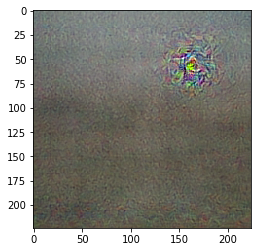

In [306]:
img = Layer2_163.image
maxv = torch.max(img)
im = torch.div(img,maxv)
im = torch.clamp(img,0,1)
show_image(im.cpu())

In [307]:
Layer2_163.reset()
Layer2_163.optimize(node = 9367)

Iteration: 100 Loss -15.73
Iteration: 200 Loss -17.29
Iteration: 300 Loss -18.28
Iteration: 400 Loss -19.03


tensor([[[[0.5141, 0.5311, 0.5316,  ..., 0.4420, 0.4405, 0.4512],
          [0.5174, 0.5232, 0.5482,  ..., 0.4422, 0.4397, 0.4613],
          [0.4606, 0.4388, 0.4833,  ..., 0.4624, 0.4435, 0.4618],
          ...,
          [0.3033, 0.2964, 0.3067,  ..., 0.3832, 0.3586, 0.3233],
          [0.2903, 0.2911, 0.2927,  ..., 0.3491, 0.3397, 0.3274],
          [0.3007, 0.2876, 0.2743,  ..., 0.3380, 0.3491, 0.3505]],

         [[0.5205, 0.5456, 0.5553,  ..., 0.4799, 0.4814, 0.4927],
          [0.5170, 0.5315, 0.5676,  ..., 0.4808, 0.4824, 0.5042],
          [0.4475, 0.4340, 0.4859,  ..., 0.4932, 0.4813, 0.4985],
          ...,
          [0.2905, 0.2788, 0.2951,  ..., 0.3832, 0.3542, 0.3154],
          [0.2913, 0.2915, 0.3015,  ..., 0.3628, 0.3409, 0.3294],
          [0.3032, 0.2881, 0.2805,  ..., 0.3558, 0.3519, 0.3571]],

         [[0.4960, 0.5014, 0.5007,  ..., 0.4899, 0.5005, 0.5109],
          [0.4940, 0.4919, 0.5210,  ..., 0.4839, 0.4921, 0.5142],
          [0.4460, 0.4253, 0.4686,  ..., 0

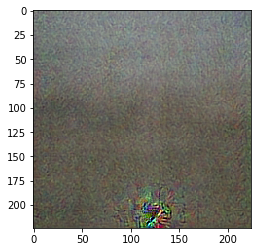

In [308]:
img = Layer2_163.image
maxv = torch.max(img)
im = torch.div(img,maxv)
im = torch.clamp(img,0,1)
show_image(im.cpu())

In [309]:
# ImageNet

In [310]:
Layer2ImNet = Layer2Activation()
Layer2ImNet.load_state_dict(ArchNet.module.state_dict())
Layer2ImNet.to("cuda:0")
print("done")

done


In [313]:
Layer2_Im = HiddenLayerOptimalImage(Layer2ImNet,initial = natural_init)

In [314]:
Layer2_Im.optimize(node = 100351)

Iteration: 100 Loss -19.94
Iteration: 200 Loss -22.02
Iteration: 300 Loss -22.83
Iteration: 400 Loss -23.18


tensor([[[[ 0.4566,  0.4067,  0.4820,  ...,  0.4584,  0.4614,  0.5124],
          [ 0.4226,  0.4618,  0.5258,  ...,  0.4807,  0.3921,  0.4807],
          [ 0.4693,  0.4222,  0.5511,  ...,  0.3923,  0.3929,  0.4421],
          ...,
          [ 0.3020,  0.3312,  0.3226,  ...,  0.9081,  0.9225,  0.4479],
          [ 0.3230,  0.3142,  0.3271,  ...,  0.1731,  1.0925,  0.9592],
          [ 0.3279,  0.3309,  0.3285,  ...,  0.4114,  0.0107,  0.8163]],

         [[ 0.5263,  0.4685,  0.5119,  ...,  0.5409,  0.5620,  0.6269],
          [ 0.4650,  0.5231,  0.5579,  ...,  0.5255,  0.4752,  0.5476],
          [ 0.4773,  0.4251,  0.5418,  ...,  0.4270,  0.4570,  0.4457],
          ...,
          [ 0.3118,  0.3601,  0.3345,  ..., -0.0450,  0.5863,  0.6066],
          [ 0.3279,  0.3244,  0.3374,  ..., -0.9594,  0.8948,  1.3828],
          [ 0.3243,  0.3332,  0.3288,  ..., -0.3350, -0.4743,  0.9420]],

         [[ 0.5049,  0.4594,  0.4667,  ...,  0.5160,  0.5679,  0.6143],
          [ 0.4697,  0.4856,  

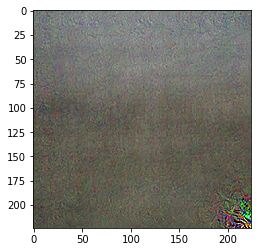

In [315]:
img = Layer2_Im.image
maxv = torch.max(img)
im = torch.div(img,maxv)
im = torch.clamp(img,0,1)
show_image(im.cpu())

Iteration: 100 Loss -11.90
Iteration: 200 Loss -12.52
Iteration: 300 Loss -12.82
Iteration: 400 Loss -13.05


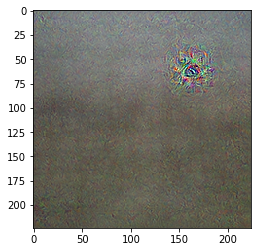

In [316]:
Layer2_Im.reset()
Layer2_Im.optimize(node = 1000)
img = Layer2_Im.image
maxv = torch.max(img)
im = torch.div(img,maxv)
im = torch.clamp(img,0,1)
show_image(im.cpu())

Iteration: 100 Loss -14.43
Iteration: 200 Loss -18.77
Iteration: 300 Loss -20.39
Iteration: 400 Loss -20.87


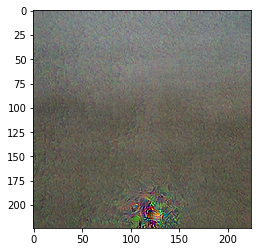

In [317]:
Layer2_Im.reset()
Layer2_Im.optimize(node = 9367)
img = Layer2_Im.image
maxv = torch.max(img)
im = torch.div(img,maxv)
im = torch.clamp(img,0,1)
show_image(im.cpu())

In [368]:
# Layer 3
class Layer3Activation(ResNet):
    def __init__(self):
        super(Layer3Activation, self).__init__(BasicBlock, [2, 2, 2, 2],num_classes = 3)
        for i in range(2):
            self.layer3[i].relu = torch.nn.RReLU()
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

In [369]:
Layer3Places = Layer3Activation()
Layer3Places.load_state_dict(ArchNet_places.state_dict())
Layer3Places.to("cuda:0")
Layer3_Places_im = HiddenLayerOptimalImage(Layer3Places,initial = natural_init)

Iteration: 100 Loss -6.67
Iteration: 200 Loss -6.91
Iteration: 300 Loss -6.99


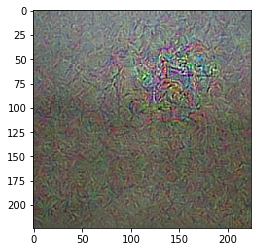

In [370]:
Layer3_Places_im.reset()
Layer3_Places_im.optimize(3200)
img = Layer3_Places_im.image
maxv = torch.max(img)
im = torch.div(img,maxv)
im = torch.clamp(img,0,1)
show_image(im.cpu())

Iteration: 100 Loss -5.60
Iteration: 200 Loss -6.05
Iteration: 300 Loss -6.19
Iteration: 400 Loss -6.30
Iteration: 100 Loss -3.91
Iteration: 200 Loss -4.75
Iteration: 300 Loss -5.26
Iteration: 400 Loss -5.50
Iteration: 100 Loss 0.77
Iteration: 200 Loss -0.34
Iteration: 300 Loss -1.13
Iteration: 400 Loss -1.80


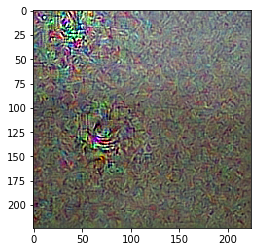

In [334]:
Layer3_Places_im.reset()
for i in range (40000,40300,100):
    Layer3_Places_im.optimize(node = i)
img = Layer3_Places_im.image
maxv = torch.max(img)
im = torch.div(img,maxv)
im = torch.clamp(img,0,1)
show_image(im.cpu())

In [371]:
Layer3Im = Layer3Activation()
Layer3Im.load_state_dict(ArchNet.module.state_dict())
Layer3Im.to("cuda:0")
Layer3_Im_im = HiddenLayerOptimalImage(Layer3Im,initial = natural_init)

Iteration: 100 Loss -8.42
Iteration: 200 Loss -8.58
Iteration: 300 Loss -8.68


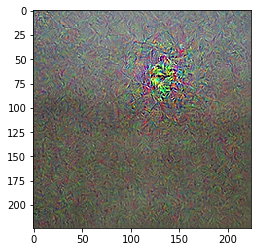

In [372]:
#Layer3_Places_im.reset()
Layer3_Im_im.optimize(node = 3200)
img = Layer3_Im_im.image
maxv = torch.max(img)
im = torch.div(img,maxv)
im = torch.clamp(img,0,1)
show_image(im.cpu())

Iteration: 100 Loss -10.69
Iteration: 200 Loss -11.06
Iteration: 300 Loss -11.16
Iteration: 400 Loss -11.19
Iteration: 100 Loss -7.22
Iteration: 200 Loss -9.37
Iteration: 300 Loss -10.05
Iteration: 400 Loss -10.36
Iteration: 100 Loss -5.80
Iteration: 200 Loss -9.62
Iteration: 300 Loss -10.61
Iteration: 400 Loss -11.10


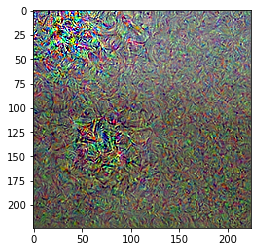

In [338]:
Layer3_Im_im.reset()
for i in range (40000,40300,100):
    Layer3_Im_im.optimize(node = i)
img = Layer3_Im_im.image
maxv = torch.max(img)
im = torch.div(img,maxv)
im = torch.clamp(img,0,1)
show_image(im.cpu())

In [373]:
# Layer 4
class Layer4Activation(ResNet):
    def __init__(self):
        super(Layer4Activation, self).__init__(BasicBlock, [2, 2, 2, 2],num_classes = 3)
        for i in range(2):
            self.layer4[i].relu = torch.nn.RReLU()
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

In [374]:
Layer4Places = Layer4Activation()
Layer4Places.load_state_dict(ArchNet_places.state_dict())
Layer4Places.to("cuda:0")
Layer4_Places_im = HiddenLayerOptimalImage(Layer4Places,initial = natural_init)

Iteration: 100 Loss -7.64
Iteration: 200 Loss -8.38
Iteration: 300 Loss -8.22


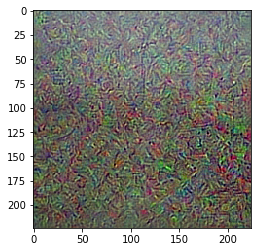

In [375]:
Layer4_Places_im.reset()
Layer4_Places_im.optimize(node = 5088)
img = Layer4_Places_im.image
maxv = torch.max(img)
im = torch.div(img,maxv)
im = torch.clamp(img,0,1)
show_image(im.cpu())

Iteration: 100 Loss -7.88
Iteration: 200 Loss -8.58
Iteration: 300 Loss -8.48


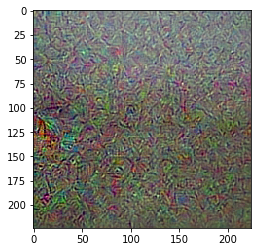

In [376]:
Layer4_Places_im.reset()
Layer4_Places_im.optimize(node = 1400)
img = Layer4_Places_im.image
maxv = torch.max(img)
im = torch.div(img,maxv)
im = torch.clamp(img,0,1)
show_image(im.cpu())

In [377]:
Layer4Im = Layer4Activation()
Layer4Im.load_state_dict(ArchNet.module.state_dict())
Layer4Im.to("cuda:0")
Layer4_Im_im = HiddenLayerOptimalImage(Layer4Im,initial = natural_init)

Iteration: 100 Loss -13.35
Iteration: 200 Loss -14.60
Iteration: 300 Loss -14.84


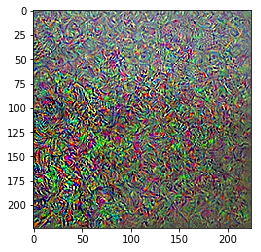

In [378]:
Layer4_Im_im.reset()
Layer4_Im_im.optimize(node = 1400)
img = Layer4_Im_im.image
maxv = torch.max(img)
im = torch.div(img,maxv)
im = torch.clamp(img,0,1)
show_image(im.cpu())